In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

PROJECT_DIR = os.path.join(os.path.dirname('augmentation.ipynb'), os.pardir) + '/..'

In [3]:
# Reading the up-sampled dataset
train_df = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_train.csv', usecols=['Description', 'Accident Level'])
train_df.head()

,Description,Accident Level
0,By manually moving a steel cabinet for disposa...,3
1,Once the mooring of the faneles in the detonat...,1
2,When performing cleaning activity of the area ...,3
3,The technician was doing the magnetometric sur...,1
4,The operator cleaned with spatula spear throug...,1


# Pre-processing

In [4]:
# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords

# to remove common stop words
from nltk.corpus import stopwords

# to generate a wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suhai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def process_description(df):
    # To lowercase
    df['description_processed'] = df['Description'].apply(lambda x: x.lower())

    # Removing non-alpha-numeric chars
    df['description_processed'] = df['description_processed'].apply(lambda x: ''.join(re.sub('[^A-Za-z0-9\s]+', '', x)))

    # Removing extra white spaces
    df['description_processed'] = df['description_processed'].str.strip()

    # Removing stop-words
    df['description_processed'] = df['description_processed'].progress_apply(
        lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))
    
    return df

In [6]:
train_df = process_description(train_df)
train_df.head()

100%|██████████| 1155/1155 [00:23<00:00, 49.22it/s]


,Description,Accident Level,description_processed
0,By manually moving a steel cabinet for disposa...,3,manually moving steel cabinet disposal help an...
1,Once the mooring of the faneles in the detonat...,1,mooring faneles detonating cord completed inju...
2,When performing cleaning activity of the area ...,3,performing cleaning activity area near 042tc06...
3,The technician was doing the magnetometric sur...,1,technician magnetometric survey stepped thorn ...
4,The operator cleaned with spatula spear throug...,1,operator cleaned spatula spear one windows boi...


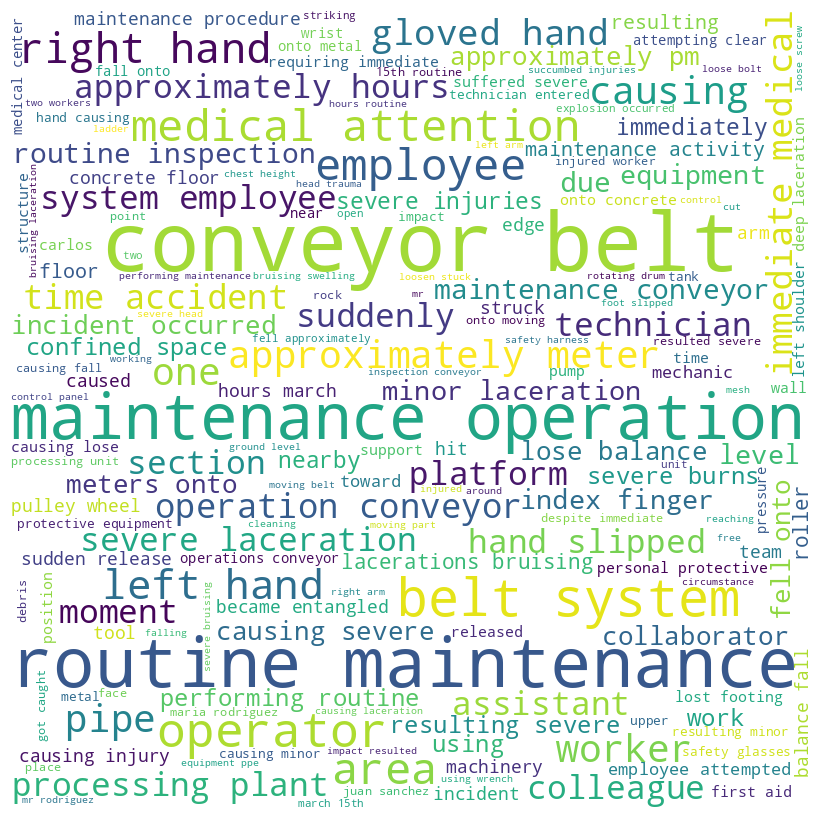

In [7]:
# Generating wordcloud
word_cloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10)
word_cloud.generate(' '.join(list(train_df['description_processed'])))

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show();

In [8]:
from sklearn.model_selection import train_test_split

# Splitting feature and target variables
X = train_df['description_processed']
Y = train_df['Accident Level']

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)

# Displaying the shape of dataframe after split
print("The shape for data frame X_train")
print(x_train.shape)
print("The shape for data frame X_test")
print(x_val.shape)
print("The shape for data frame y_train")
print(y_train.shape)
print("The shape for data frame y_test")
print(y_val.shape)

The shape for data frame X_train
(924,)
The shape for data frame X_test
(231,)
The shape for data frame y_train
(924,)
The shape for data frame y_test
(231,)


# EXP

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPool1D, Dropout
from tensorflow.keras.metrics import Recall, Precision

In [26]:
# Tokenizer
tokenizer = TextVectorization(
    max_tokens=4400,
    output_mode='int',
    output_sequence_length=200
)

tokenizer.adapt(x_train)

In [27]:
tokenizer.get_vocabulary()

['',
 '[UNK]',
 'causing',
 'hand',
 'right',
 'employee',
 'left',
 'operator',
 'time',
 'injury',
 'activity',
 'accident',
 'moment',
 'work',
 'level',
 'equipment',
 'pipe',
 'finger',
 'collaborator',
 'area',
 'mesh',
 'floor',
 'assistant',
 'safety',
 'worker',
 'support',
 'rock',
 'one',
 'mr',
 'team',
 'meters',
 'injured',
 'part',
 'kg',
 'approximately',
 'height',
 'gloves',
 'described',
 'truck',
 'side',
 'used',
 'face',
 'metal',
 'circumstances',
 'performing',
 'made',
 'towards',
 'pump',
 'using',
 'two',
 'performed',
 'medical',
 'hits',
 'generating',
 'foot',
 'maintenance',
 'hit',
 'cut',
 'structure',
 'cm',
 'cleaning',
 'access',
 'remove',
 'position',
 'platform',
 'hitting',
 'back',
 'place',
 'front',
 'falls',
 'x',
 'plate',
 'end',
 'workers',
 'weight',
 'moving',
 'key',
 'ground',
 'activities',
 'reports',
 'fall',
 'drilling',
 'drill',
 'car',
 'wearing',
 'water',
 'tube',
 'point',
 'moments',
 'inside',
 'hose',
 'arm',
 '2',
 'vehic

In [28]:
tokenizer(x_train[950])

KeyError: 950

In [29]:
x_train = tokenizer(x_train)
x_val = tokenizer(x_val)

In [37]:
# Standardization
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler().fit(x_train)
x_train_std = pd.DataFrame(std_scaler.transform(x_train), columns=x_train.columns)
x_val_std = pd.DataFrame(std_scaler.transform(x_val), columns=x_train.columns)

x_train_std.describe().T

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'columns'

In [28]:
# Model building
model = Sequential([
    Input(dtype=tf.string, shape=(1,)),
    tokenizer,
    Embedding(
        input_dim=len(tokenizer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

In [41]:
emb = Embedding(len(tokenizer.get_vocabulary()), 200, mask_zero=True)
emb.adapt(x_train)

AttributeError: 'Embedding' object has no attribute 'adapt'

In [47]:
model = Sequential()
model.add(Embedding(len(tokenizer.get_vocabulary()), 200, mask_zero=True))
model.add((LSTM(256, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(5, activation = 'softmax'))

In [48]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.00000001), metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 200)         595600    
                                                                 
 lstm_7 (LSTM)               (None, None, 256)         467968    


                                                                 
 global_max_pooling1d_7 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 5)                 325       
          

In [49]:
# Fit model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=8, verbose=1)

Epoch 1/30
42/42 [==============================] - 35s 161ms/step - loss: nan - accuracy: 0.0180 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/30
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/30
42/42 [==============================] - 1s 22ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/30
42/42 [==============================] - 1s 23ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/30
42/42 [==============================] - 1s 24ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/30
42/42 [==============================] - 1s 22ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/30
42/42 [==============================] - 1s 22ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
E

In [8]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 300
num_distinct_words = 5000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [10]:
# Pad all sequences
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_val, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

ValueError: invalid literal for int() with base 10: 'xture methane air depth approximately 120 meters surface blast caused significant damage surrounding infrastructure including collapsed walls debris blocking access routes two workers juan sanchez ma

In [ ]:
# Define the Keras model
model = Sequential()
model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
model.add(LSTM(10))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
model.summary()

In [ ]:
# Train the model
history = model.fit(padded_inputs, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split)

In [ ]:
# Test the model after training
test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

# GloVe

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPool1D, Dropout
from tensorflow.keras.metrics import Recall, Precision

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.optimizers import SGD

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.models import Model

In [9]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

X_text_train = tokenizer.texts_to_sequences(x_train)
X_text_test = tokenizer.texts_to_sequences(x_val)

X_text_train

[[442,
  33,
  159,
  200,
  7,
  1,
  17,
  209,
  712,
  241,
  1267,
  122,
  37,
  24,
  1135,
  786,
  1268,
  201,
  999,
  5,
  352,
  22,
  95,
  202,
  20,
  210,
  277,
  208,
  1000,
  300,
  663,
  1494,
  99,
  1495,
  58,
  1496,
  50,
  73,
  105,
  156,
  83,
  92,
  229,
  290,
  12,
  13,
  28,
  177,
  664,
  331,
  353,
  452,
  1269],
 [191,
  114,
  1270,
  713,
  787,
  145,
  2547,
  2548,
  278,
  341,
  152,
  872,
  341,
  58,
  192,
  1852,
  1001,
  873,
  1497,
  153,
  152,
  55,
  2549,
  2550,
  117,
  38,
  713,
  787,
  332,
  44,
  8,
  211],
 [186,
  279,
  120,
  51,
  9,
  160,
  325,
  76,
  280,
  123,
  874,
  24,
  127,
  86,
  36,
  63,
  100,
  291,
  18,
  272,
  1271,
  93,
  187,
  8,
  6,
  39,
  110,
  406,
  20,
  63,
  875,
  311,
  112,
  146,
  59,
  10,
  6,
  23,
  128,
  25,
  44],
 [5,
  2551,
  102,
  407,
  665,
  62,
  2552,
  9,
  1853,
  2553,
  114,
  714,
  1854,
  24,
  133,
  99,
  248,
  27,
  78,
  509,
  249,
  56,
 

In [10]:
# Sentences can have different lengths, and therefore the sequences returned by the Tokenizer class also consist of variable lengths.
# We need to pad the our sequences using the max length.
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 100

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 4319


In [21]:
# Convert both the training and test labels into one-hot encoded vectors:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

In [23]:
y_val

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
# We need to load the built-in GloVe word embeddings
embedding_size = 200
embeddings_dictionary = dict()

glove_file = open(f'{PROJECT_DIR}/models/glove.6B.200d/glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

len(embeddings_dictionary.values())

400000

In [24]:
# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = Dense(6, activation='softmax')(drop_out_layer_5)
#dense_layer_3 = Dense(5, activation='softmax')(drop_out_layer_3)

# LSTM_Layer_1 = LSTM(128)(embedding_layer)
# dense_layer_1 = Dense(5, activation='softmax')(LSTM_Layer_1)
# model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model = Model(inputs=deep_inputs, outputs=dense_layer_5)
#model = Model(inputs=deep_inputs, outputs=dense_layer_3)

opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 200)          863800    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         336896    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               3289

In [26]:
class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, validation_data=()):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal, target_type = self.validation_data
        if target_type == 'multi_class':
          val_predict_classes = model.predict_classes(xVal, verbose=0) # Multiclass
        else:
          val_predict_classes = (np.asarray(self.model.predict(xVal))).round() # Multilabel

In [28]:
# Use earlystopping
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=1E-3)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=5, min_delta=1E-4)

target_type = 'multi_label'
metrics = Metrics(validation_data=(X_text_train, y_train, target_type))

# fit the keras model on the dataset
training_history = model.fit(X_text_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_text_test, y_val), callbacks=[rlrp, metrics])

Epoch 1/100
116/116 [==============================] - 3s 28ms/step - loss: 1.0090 - acc: 0.5606 - val_loss: 1.0747 - val_acc: 0.5411 - lr: 1.0000e-19
Epoch 2/100
116/116 [==============================] - 3s 26ms/step - loss: 1.0321 - acc: 0.5357 - val_loss: 1.0747 - val_acc: 0.5411 - lr: 1.0000e-19
Epoch 3/100
116/116 [==============================] - 3s 26ms/step - loss: 1.0246 - acc: 0.5552 - val_loss: 1.0747 - val_acc: 0.5411 - lr: 1.0000e-19
Epoch 4/100
116/116 [==============================] - 3s 27ms/step - loss: 1.0282 - acc: 0.5422 - val_loss: 1.0747 - val_acc: 0.5411 - lr: 1.0000e-19
Epoch 5/100
116/116 [==============================] - 3s 25ms/step - loss: 1.0244 - acc: 0.5455 - val_loss: 1.0747 - val_acc: 0.5411 - lr: 1.0000e-19
Epoch 6/100
116/116 [==============================] - 3s 26ms/step - loss: 1.0247 - acc: 0.5465 - val_loss: 1.0747 - val_acc: 0.5411 - lr: 1.0000e-19
Epoch 7/100
116/116 [==============================] - 3s 27ms/step - loss: 1.0197 - acc: 0.55